In [12]:
import numpy as np
import plotters as plot
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import check_seasonality,plot_acf,plot_pacf,remove_seasonality,remove_trend,stationarity_test_adf
from darts.utils.statistics import extract_trend_and_seasonality
import os
from meteostat import Point, Hourly
import holidays
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]


list_data = os.listdir('./data')
csv_data = [n for n in list_data if n.endswith('.csv')]
for csv in sorted(csv_data):
    print(csv)

AEP_hourly.csv
COMED_hourly.csv
DAYTON_hourly.csv
DEOK_hourly.csv
DOM_hourly.csv
DUQ_hourly.csv
EKPC_hourly.csv
FE_hourly.csv
NI_hourly.csv
PJME_hourly.csv
PJMW_hourly.csv
PJM_Load_hourly.csv
pjm_hourly_est.csv


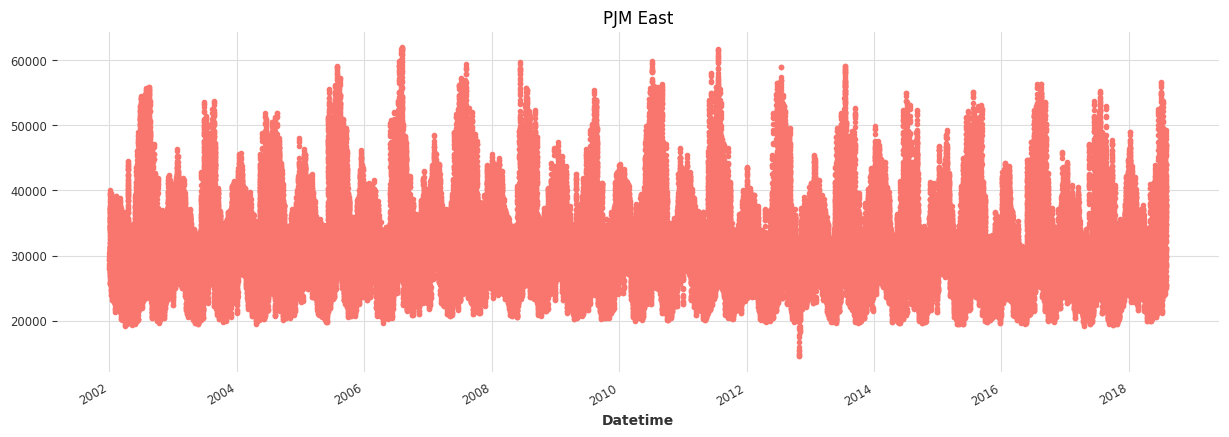

In [13]:
pjme_df = pd.read_csv('./data/PJME_hourly.csv', delimiter=',', nrows = None, parse_dates=['Datetime'])
pjme_df['Datetime'] = pd.to_datetime(pjme_df['Datetime'])
us_holidays = holidays.US()
def is_holiday(date):
    return date in us_holidays
pjme_df['is_holiday'] = pjme_df['Datetime'].apply(is_holiday)

pjme_df.set_index('Datetime', inplace=True)

_ = pjme_df['PJME_MW'].plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')


In [38]:
philly = Point(39.9526, -75.1652)

start = pjme_df.index.min()
end = pjme_df.index.max()
temp_data = Hourly(philly, start, end)
temp_data = temp_data.fetch()
pjme_df = pjme_df.merge(temp_data[['temp']], left_index=True, right_index=True, how='left')
pjme_df['is_weekend'] = pjme_df.index.dayofweek.isin([5, 6])
pjme_df['day_name'] = pjme_df.index.day_name()

def create_features(
                    df: pd.DataFrame,
                    label=None
    ) -> pd.DataFrame | tuple[pd.DataFrame, pd.Series]: 
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week

    col = df.columns.tolist()
    
    if label:
        col.remove(label)
        return df[col], df[label]
    return df

X, y = create_features(pjme_df, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)


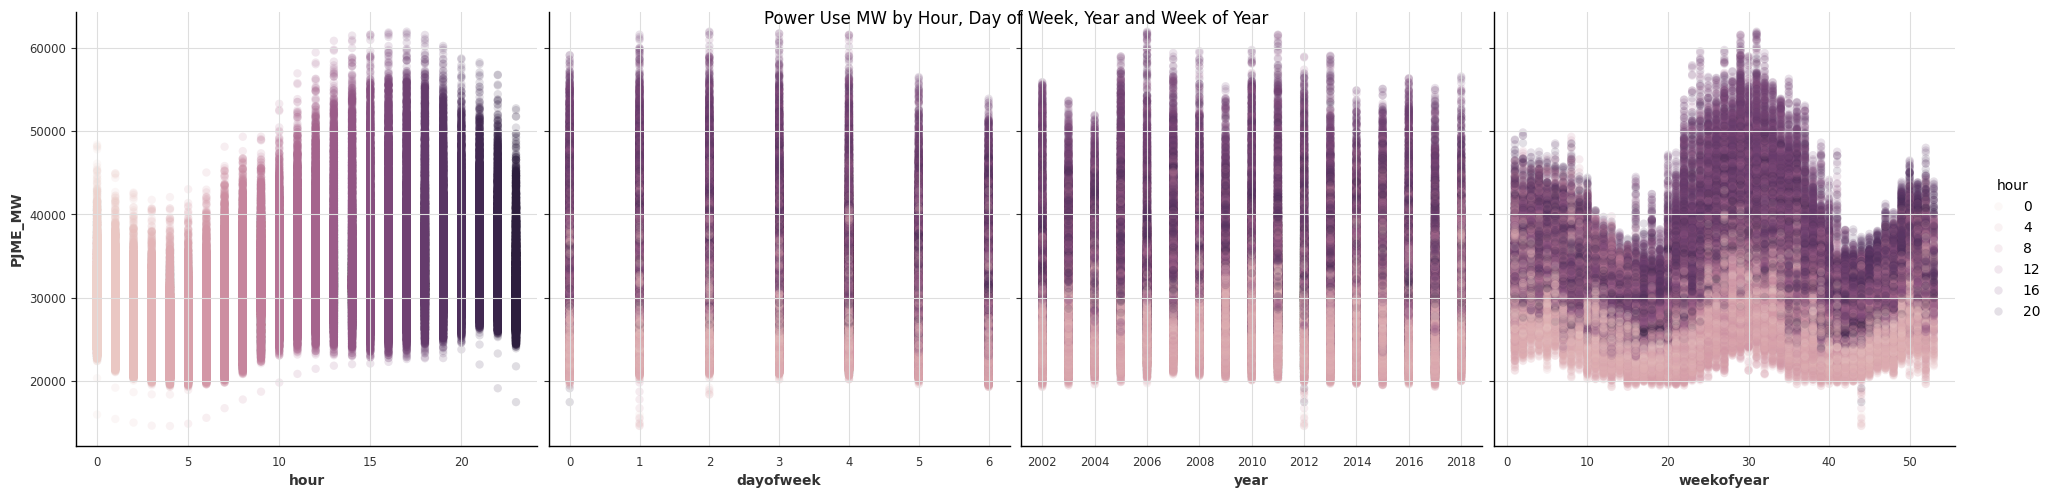

In [15]:


sns.pairplot(features_and_target.dropna(),
            hue='hour',
            x_vars=['hour','dayofweek',
                    'year','weekofyear'],
            y_vars='PJME_MW',
            height=5,
            plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()



In [19]:
split_date = datetime(2016, 1, 1)
pjme_train = features_and_target.loc[features_and_target.index <= split_date].copy()
pjme_test = features_and_target.loc[features_and_target.index > split_date].copy()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.


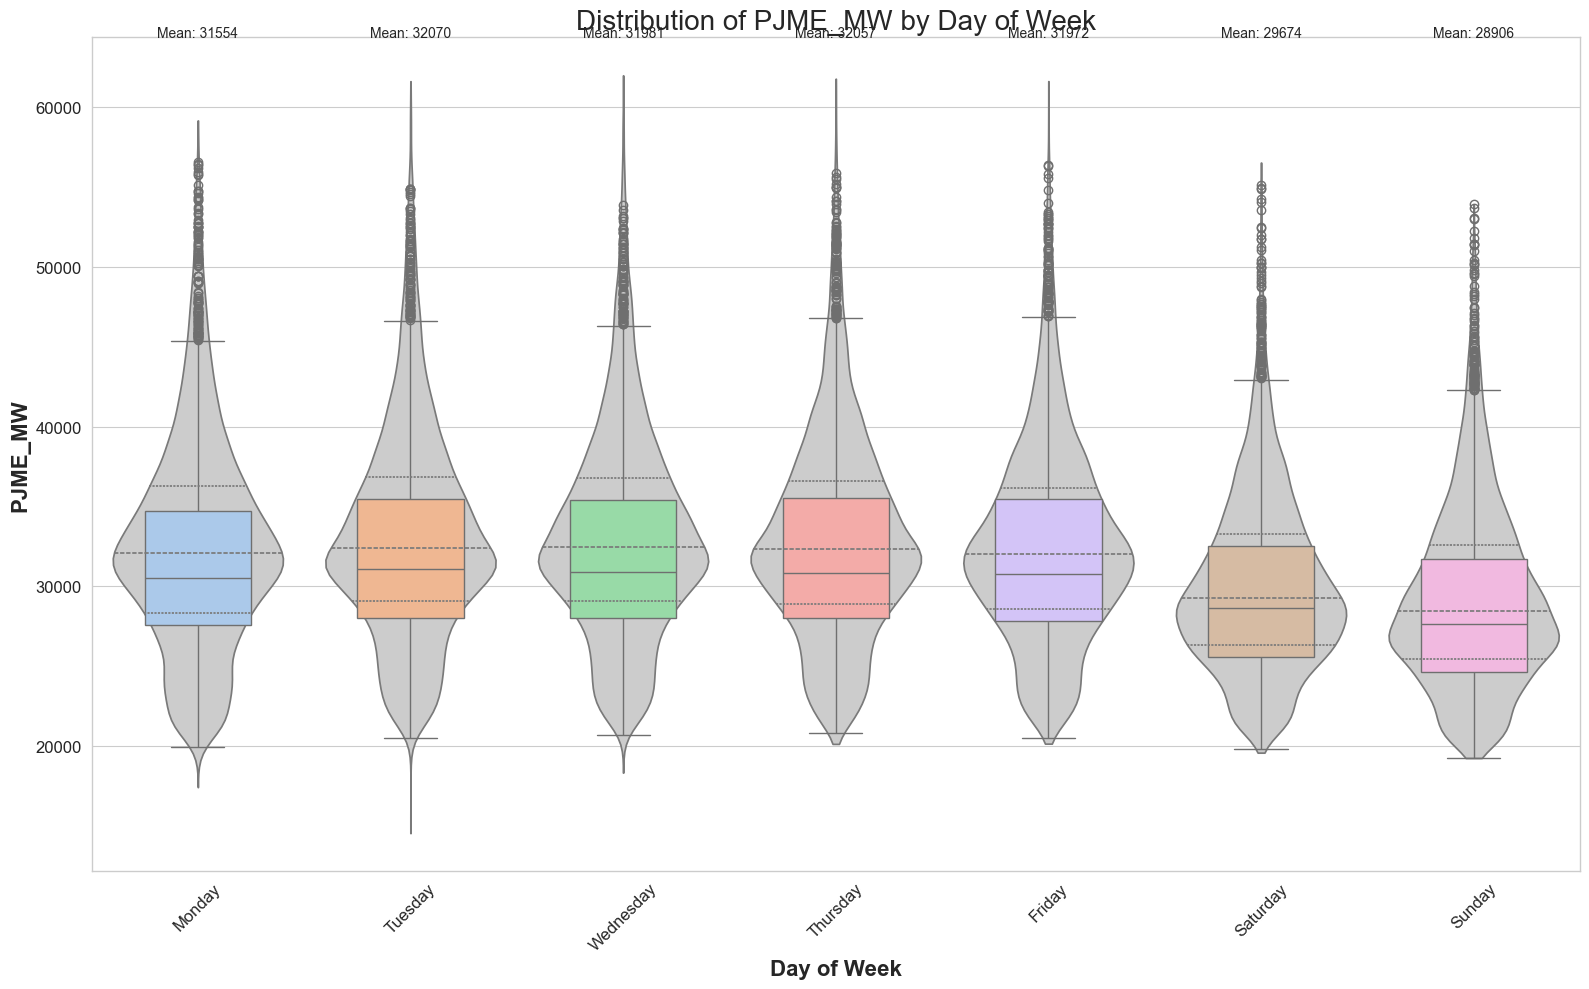

In [20]:
# Create a custom order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set the style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(16, 10))

# Create the box plot
sns.boxplot(x='day_name', y='PJME_MW', data=pjme_test, order=day_order, 
            palette='pastel', width=0.5)

# Create the violin plot
sns.violinplot(x='day_name', y='PJME_MW', data=pjme_df, order=day_order,
            scale='width', inner='quartile', cut=0, color=".8")

# Customize the plot
plt.title('Distribution of PJME_MW by Day of Week', fontsize=20)
plt.xlabel('Day of Week', fontsize=16)
plt.ylabel('PJME_MW', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add some statistics
for i, day in enumerate(day_order):
    day_data = pjme_test[pjme_test['day_name'] == day]['PJME_MW']
    mean = day_data.mean()
    plt.text(i, plt.ylim()[1], f'Mean: {mean:.0f}', 
            horizontalalignment='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [29]:
pjme_test[['month','PJME_MW']]

,month,PJME_MW
Datetime,,
2016-12-31 01:00:00,12,29627.0
2016-12-31 02:00:00,12,28744.0
2016-12-31 03:00:00,12,28274.0
2016-12-31 04:00:00,12,28162.0
2016-12-31 05:00:00,12,28434.0
...,...,...
2018-01-01 20:00:00,1,44284.0
2018-01-01 21:00:00,1,43751.0
2018-01-01 22:00:00,1,42402.0



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

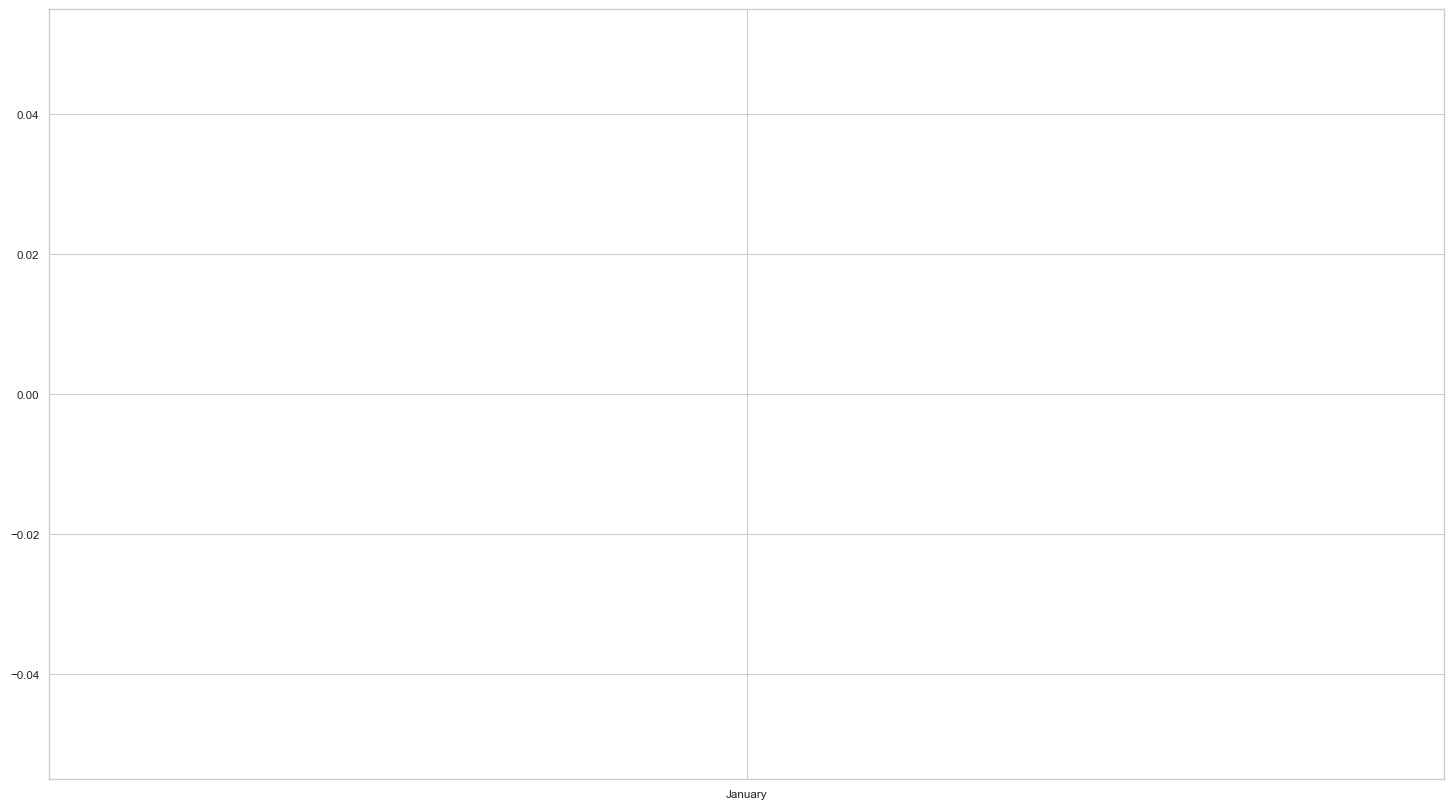

In [30]:
# Create a custom order for months of the year
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
            'July', 'August', 'September', 'October', 'November', 'December']

# Set the style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(18, 10))

# Create the box plot
sns.boxplot(x='month', y='PJME_MW', data=pjme_test, order=month_order, 
            palette='pastel', width=0.5)

# Create the violin plot
sns.violinplot(x='month', y='PJME_MW', data=pjme_test, order=month_order,
            scale='width', inner='quartile', cut=0, color=".8")

# Customize the plot
plt.title('Distribution of PJME_MW by Month of Year', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('PJME_MW', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add some statistics
for i, month in enumerate(month_order):
    month_data = pjme_df[pjme_df['month'] == month]['PJME_MW']
    mean = month_data.mean()
    plt.text(i, plt.ylim()[1], f'Mean: {mean:.0f}', 
            horizontalalignment='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

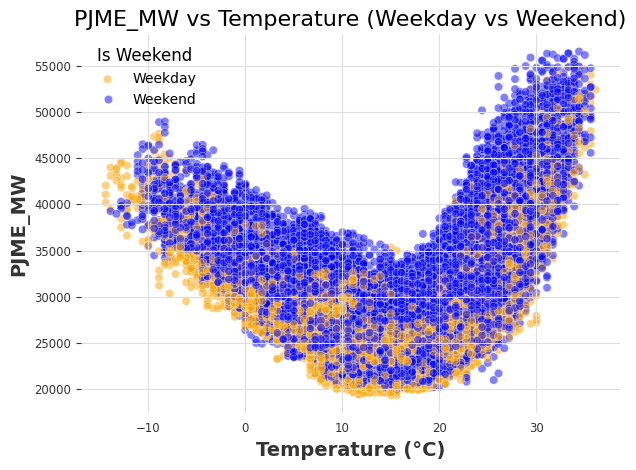

In [ ]:

# Create the plot
sns.scatterplot(data=pjme_test, 
                x='temp', 
                y='PJME_MW', 
                hue='is_weekend',
                palette={False: 'blue', True: 'orange'},
                alpha=0.5)

# Customize the plot
plt.title('PJME_MW vs Temperature (Weekday vs Weekend)', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('PJME_MW', fontsize=14)

# Customize the legend
plt.legend(title='Is Weekend', labels=['Weekday', 'Weekend'], title_fontsize=12, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
        how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()


NameError: name 'pjme_test' is not defined

In [13]:
time_diff

Datetime
2002-12-31 01:00:00               NaT
2002-12-31 02:00:00   0 days 01:00:00
2002-12-31 03:00:00   0 days 01:00:00
2002-12-31 04:00:00   0 days 01:00:00
2002-12-31 05:00:00   0 days 01:00:00
                            ...      
2018-01-01 20:00:00   0 days 01:00:00
2018-01-01 21:00:00   0 days 01:00:00
2018-01-01 22:00:00   0 days 01:00:00
2018-01-01 23:00:00   0 days 01:00:00
2018-01-02 00:00:00   0 days 01:00:00
Name: Datetime, Length: 145366, dtype: timedelta64[ns]